In [254]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [255]:
import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge
rpy.set_seed(42) 

In [256]:
from sklearn.metrics import r2_score 
from sklearn.model_selection import train_test_split   

# SINAL APRBS DO BCS

In [257]:
# Parâmetros do sinal 
t_final, dt = 1000, 1             # final e passo
t = np.arange(0, t_final, dt)
min_step, max_step = 60/60, 600/60 # tempo entre trocas 


FRENQUÊNCIA:

In [258]:
# Sinal de Frequência APRBS
min_value_f, max_value_f = 35, 60   # limites
f = np.zeros_like(t)

current_value = np.random.uniform(min_value_f, max_value_f)
time_next_change = 0

for i in range(len(t)):
    if t[i] >= time_next_change:
        current_value = np.random.uniform(min_value_f, max_value_f)
        time_next_change = t[i] + np.random.uniform(min_step, max_step)
        #print(time_next_change-t[i])
    f[i] = current_value

ABERTURA DE VÁLVULA:

In [259]:
# Sinal de Abertura APRBS
min_value_zc, max_value_zc = 0, 100   # limites
Zc = np.zeros_like(t)

current_value = np.random.uniform(min_value_zc, max_value_zc)
time_next_change = 0

for i in range(len(t)):
    if t[i] >= time_next_change:
        current_value = np.random.uniform(min_value_zc, max_value_zc)
        time_next_change = t[i] + np.random.uniform(min_step, max_step)
        #print(time_next_change-t[i])
    Zc[i] = current_value

PLOT GRÁFICO:

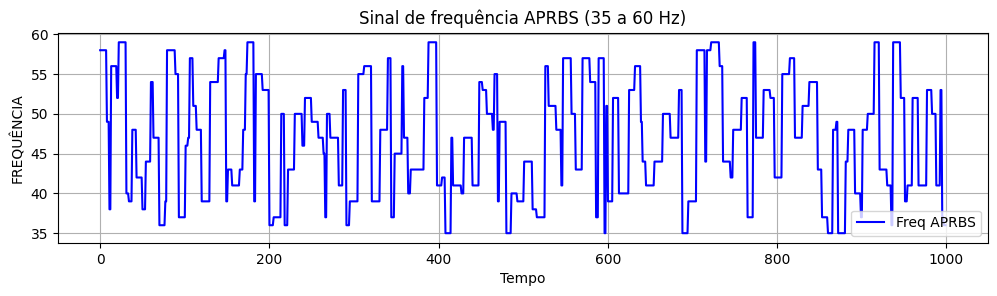

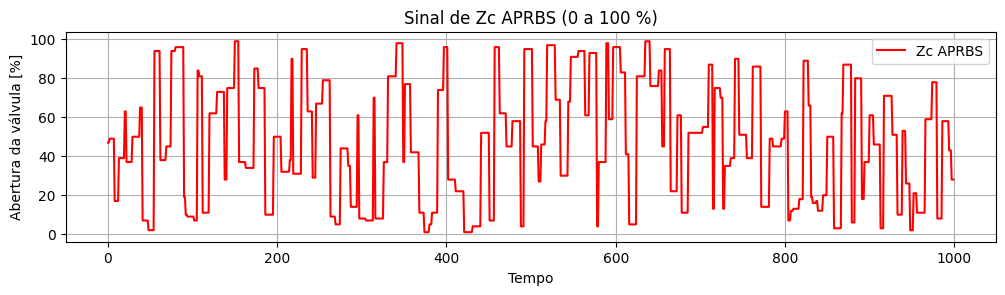

In [260]:
plt.figure(figsize=(12,6))
plt.subplot(2, 1, 1)  # (n_linhas, n_colunas, índice)
plt.plot(t, f, label="Freq APRBS", color='b')
plt.xlabel("Tempo")
plt.ylabel("FREQUÊNCIA")
plt.title("Sinal de frequência APRBS (35 a 60 Hz)")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 2)  # (n_linhas, n_colunas, índice)
plt.plot(t, Zc, label="Zc APRBS", color='r')
plt.xlabel("Tempo")
plt.ylabel("Abertura da válvula [%]")
plt.title("Sinal de Zc APRBS (0 a 100 %)")
plt.grid(True)
plt.legend()
plt.show()

ARQUIVO CSV:

In [261]:
Entradas = pd.DataFrame({
    "f(Hz)": f,
    "Zc(%)": Zc
})
print(Entradas)
 
Entradas.to_csv("Entradas_BCS.csv", index=False)
Entradas.to_excel("Entradas_BCS.xlsx", index=False)
 
 

     f(Hz)  Zc(%)
0       58     47
1       58     47
2       58     49
3       58     49
4       58     49
..     ...    ...
995     37     43
996     37     43
997     36     28
998     36     28
999     36     28

[1000 rows x 2 columns]


# IMPORTE RESPOSTAS

In [262]:
Saidas = pd.read_excel("Saidas_xlsx.xlsx")
Saidas = Saidas.to_numpy()
P_in = Saidas[:,0].reshape(-1,1)
H = Saidas[:,1].reshape(-1,1)
print(P_in.shape)
print(H.shape)

(1000, 1)
(1000, 1)


# GERANDO MODELO

ESTRUTURA:

In [263]:
reservoir = Reservoir(100, lr=0.5, sr=0.9)
readout = Ridge(ridge=1e-7)

BCS_model = reservoir >> readout

DIVISÃO DE DADOS:

In [264]:
x_aux, y_aux = Entradas[500:], Saidas[500:]

# Treino 
X_train, Y_train = Entradas[:500], Saidas[:500]
# Teste
X_test, Y_test = x_aux[:250], y_aux[:250]
# Validação
X_valid, Y_valid = x_aux[250:], y_aux[250:]

print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

(500, 2)
(250, 2)
(250, 2)


TREINAMENTO:

In [265]:
BCS_model = BCS_model.fit(X_train, Y_train, warmup=20)

VERIFICANDO INICIALIZAÇÃO:

In [266]:
print(reservoir.initialized, readout.initialized)

True True


RESULTADO:

(250,)
[357.43708395 441.21324632 460.37909995 465.97145595 465.35050718
 465.09617938 465.16766582 465.20550169 465.21238452 474.39694759
 480.07960034 373.06337915 353.84069654 346.22332334 348.21463599
 348.80269727 332.64698906 327.56545941 326.45845746 320.82477628
 321.59718713 322.51556875 322.61119251 322.57923398 322.57061725
 322.57110924 667.42081623 703.16269651 711.42962792 721.16838161
 617.41404486 606.39012057 604.17734566 604.2909932  604.32404997
 622.90998345 633.45397931 636.48644547 638.15819435 577.07603036
 570.36133564 568.76397875 569.25568516 569.4334188  542.8701413
 406.99147092 397.94750392 697.06231175 729.67943007 737.13531871
 737.96566953 738.08605016 738.11999513 738.12883664 738.13077447
 738.13118401 737.27444995 591.62246821 578.91346042 575.80333381
 575.68063382 575.70576534 445.26942133 434.70288741 437.34665387
 438.38528781 437.86237961 437.68529129 437.67011529 430.3937477
 701.92043181 730.54536131 736.80516386 737.48131517 737.57605623
 737.

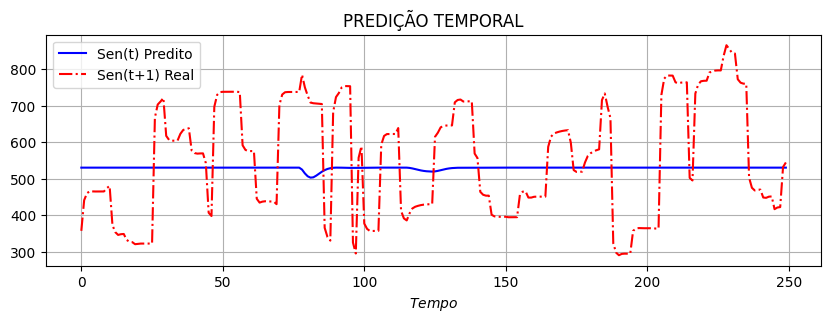

In [280]:

Y_pred = BCS_model.run(X_test)
print(Y_pred[:,1].shape)
print(Y_test[:,1])
plt.figure(figsize=(10, 3))
plt.title("PREDIÇÃO TEMPORAL")
plt.xlabel("$Tempo$")
plt.plot(Y_pred[:,1], label="Sen(t) Predito", color="blue", linestyle="-")
plt.plot(Y_test[:,1], label="Sen(t+1) Real", color="red", linestyle="-.")
plt.grid()
plt.legend()
plt.show()


MÉTRICA:

In [270]:
print(Y_pred[1], Y_test[0])
R2 = r2_score(Y_pred[0], Y_test[0])
print(f"R2: {R2}")

[6.87779934e+06 5.30116670e+02] [7.01912580e+06 3.57437084e+02]
R2: 0.9992467130809944
